# 0. Pre

## Introduction
The purpose of this notebook is to teach you some essentials about the Pytorch library. We will also implement our own dataloader, model, and trainer, so that after we train the model, it can distinguish between different cloths!

## Requirements

In [2]:
!pip install -q numpy torch torchvision pillow tqdm

## Imports

In [3]:
from copy import deepcopy
from math import ceil

import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score
from torchvision.datasets import FashionMNIST
from tqdm.notebook import tqdm

# 1. Data

## Dataset and Dataloader

### Dataset
We will use Fashion-MNIST dataset for our experiments in this notebook. It is a small dataset, so you will not need a GPU for your training.

In [4]:
# Making datasets
train_set = FashionMNIST(root='fashion-mnist', download=True, train=True)
test_set = FashionMNIST(root='fashion-mnist', download=True, train=False)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting fashion-mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fashion-mnist/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting fashion-mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fashion-mnist/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting fashion-mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fashion-mnist/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting fashion-mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fashion-mnist/FashionMNIST/raw



In [ ]:
[test_set[i][0] for i in range(3)]

[<PIL.Image.Image image mode=L size=28x28 at 0x7F50113F9750>,
 <PIL.Image.Image image mode=L size=28x28 at 0x7F50113F9790>,
 <PIL.Image.Image image mode=L size=28x28 at 0x7F50113F9850>]

In [ ]:
len(train_set)

60000

In [6]:
import matplotlib.pyplot as plt

[9558 4026  797 5500]


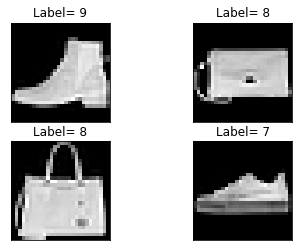

In [7]:
rand_Img=np.random.randint(1,len(test_set), size=4)
print(rand_Img)
c=0
plt.figure(facecolor='w')
for i in rand_Img:
  c=c+1
  # define subplots
  plt.subplot(2, 2, c)
  plt.title('Label= %d'%test_set[i][1])
  plt.xticks([])
  plt.yticks([])
  plt.imshow(test_set[i][0], cmap=plt.get_cmap('gray'))
plt.show()

### Dataloader
Dataloader is an object that combines a dataset and a sampler, and provides an iterable over the given dataset. Pytorch has its own dataloader, but here, to understand what lies under the hood, we will implement our custom one.

In [8]:
class CustomDataloader:
    def __init__(self, dataset, batch_size, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        # images passed to the dataloader are PIL objests.
        # we need to convert those to tensors:
        self.transform = transforms.Compose([
            transforms.PILToTensor()
        ])
        
    def __len__(self):
        # return the count of batches.
        # This function is called when the instance of the CustomDataLoader object
        # is passed to len function (a predifined Python's function) 
        return int(len(self.dataset)/self.batch_size)

    def __iter__(self, calm=True):
        indexes = list(range(len(self.dataset)))

        for idx in range(0, len(self.dataset), self.batch_size):
            # In this loop we prepare a batch of data (images respective to the indexes)
            # for a single training iteration.
            # The steps are as follows:
            # 1. construct a list of images
            # 2. convert the list to tensors
            # 3. convert tensors to float32 (each tensor element should be between 0 and 1)
            # 4. construct the respective labels list
            batch_indexes = range(idx, min(idx+self.batch_size, len(self.dataset)))
            batch_imgs = [self.transform(train_set[i][0]) for i in batch_indexes]
            batch_imgs_transformed = torch.tensor([np.array(img/255,dtype='float32') for img in batch_imgs])
            batch_labels = [train_set[i][1] for i in batch_indexes]
            # The yield statement returns a generator object to the one 
            # who calls the function which contains yield, instead of simply 
            # returning a value.
            # Check the following link for more information and detailed examples:
            # https://www.geeksforgeeks.org/python-yield-keyword/
            # In other words, "yield" keeps you inside the __iter__ function 
            yield batch_imgs_transformed, torch.tensor(batch_labels) 
            
        return


In [10]:
def test_dataloader():
    # test your dataloader! 
    dataloader = CustomDataloader(train_set,256,True)
    for data, labels in dataloader:
        pass
        # print(len(data))

test_dataloader()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


In [11]:
# Initialaze the dataloaders, for training_set and test_set
# by creating an instance of our recently defined customized
# dataloader.
train_dataloader = CustomDataloader(train_set, 128, True)
test_dataloader = CustomDataloader(test_set, 128, True)

# 2. Model
Here, we will implement our network. Our model is a simple feed-forward network that gets an image, flattens the image, then passes it through several linear layers with relu activations. Note that the class should be inheritted from nn.Module. Otherwise PyTorch won't recognize it as a model.

In [12]:
class Classifier(nn.Module):
    def __init__(self, input_dims, hidden_dims, num_classes):
        super().__init__()
        # nn.ModuleList merely creates a simple array that can contain 
        # several nn.Modules. It is important to note that NO rules associated
        # with the connections between the layers is going to be defined when
        # using it. The connection between layers should be defined in 
        # the inehritted function called "forward" (this function which 
        # is available in nn.Module package is going to be overided 
        # in our "Classifier" custom defenition). There are other methods
        # for creating a PyTorch models such as Sequential and Fuctional.
        self.nn_layers = nn.ModuleList()
        self.activation = nn.ReLU()
        self.flatten = torch.flatten
        # construct layers of the network
        # these layers are stored in `self.nn_layers`
        # use `nn.Linear` for all layers
        l1=nn.Linear(input_dims[0]*input_dims[1],hidden_dims[0])
        # use `self.nn_layers.append`
        self.nn_layers.append(l1)
        for i in range(len(hidden_dims)-1):
            self.nn_layers.append(nn.Linear(hidden_dims[i],hidden_dims[i+1]))
        self.nn_layers.append(nn.Linear(hidden_dims[-1],num_classes))
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x):
        x = self.flatten(x, start_dim=1)
        # pass `x` through all the layers of the network.
        # also don't forget the activation functions!
        # don't use `softmax` in the last layer.
        for i in range(len(self.nn_layers)-1):
            x = self.nn_layers[i](x)
            x = self.activation(x)
        x = self.nn_layers[-1](x)
        return x

    def predict(self, x):
        # get the predicted class of x.
        # use softmax and then get the maximum indexes
        x = self.forward(x)
        x=self.softmax(x)
        prediction=torch.argmax(x, dim=1)
        return prediction

In [13]:
def test_model():
    input_dims = (28, 28)
    hidden_dims = [10, 100, 20]
    num_classes = 10
    batch_size = 8
    
    cls = Classifier(input_dims, hidden_dims, num_classes)
    x = torch.rand(batch_size, *input_dims)
    assert cls(x).shape == torch.Size([batch_size, num_classes])
    assert cls.predict(x).shape == torch.Size([batch_size])

    
def test_model_with_dataloader():
    input_dims = (28, 28)
    hidden_dims = [10, 100, 20]
    num_classes = 10
    batch_size = 8
    dataloader = CustomDataloader(dataset=test_set, batch_size=batch_size, shuffle=True)
    imgs, labels = next(iter(dataloader))
    cls = Classifier(input_dims, hidden_dims, num_classes)
    assert cls(imgs).shape == torch.Size([batch_size, num_classes])
    assert cls.predict(imgs).shape == torch.Size([batch_size])

test_model()
test_model_with_dataloader()

In [14]:
input_dims = (28, 28)
hidden_dims = [10, 100, 20]
num_classes = 10
batch_size = 1024
dl = CustomDataloader(dataset=test_set, batch_size=batch_size, shuffle=True)
len(dl)
# imgs, labels = next(iter(dl))
# print(len(labels))
# for step, (data, labels) in tqdm(enumerate(dl)):
#     print(len(labels))

9

# 3. Training

## Trainer
Trainer is an object that gets the model, dataloaders, optimizer and criterion and then trains the model with the given data in a training loop. 

In [32]:
class Trainer:
    def __init__(self, 
        train_dataloader, val_dataloader, model,
        optimizer, criterion, *args, **kwargs
    ):
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.model = model
        self.best_model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.train_losses = []
        self.accuracies = []
        self.val_losses = []
        self.val_loss = None
        self.min_val_loss = np.inf

    def train(self, epochs, log_each_n_percent_epoch):
        train_steps = len(self.train_dataloader)
        log_steps = int(train_steps * log_each_n_percent_epoch/100)

        for epoch in range(epochs):
            print(f"epoch {epoch+1} started".title().center(50, "="))
            train_loss = 0.0
            for step, (data, labels) in tqdm(enumerate(self.train_dataloader)):
                # first move the data and labels to gpu if you are using it
                # forward the data, calculate loss and then backpropagate it
                # Forward pass
                self.optimizer.zero_grad()

                outputs = self.model(data)

                pred_labels = torch.softmax(outputs, dim=1)

                loss = self.criterion(outputs, labels)
                
                self.train_losses.append(loss.item()) 
                # Backward and optimize
                
                loss.backward()
                self.optimizer.step()

                if step % log_steps == 1:
                    self.val_loss, accuracy = self.evaluate(save=True)
                    info_text = f'Validation Loss: {self.val_loss:.6f}\t Accuracy-score: {accuracy:.2f}'
                    print(info_text)
                    
              
            self.val_loss, accuracy = self.evaluate(save=True)
            self.val_losses.append(self.val_loss.item())
            self.accuracies.append(accuracy)

            self.post_evaluation_actions(epoch)
            


    def evaluate(self, save=False):
        with torch.no_grad():
            # run the prediction on the validation dataloader,
            # calculate loss and accuracy
            y_true, y_pred = torch.tensor([],dtype=torch.int), torch.tensor([],dtype=torch.int)
            outputs = torch.tensor([])
            n_correct = 0

            for step, (dataVal, labelsVal) in tqdm(enumerate(self.val_dataloader)):
                # first move the data and labels to gpu if you are using it
                # forward the data, calculate loss and then backpropagate it
                # Forward pass
                
                output = self.model(dataVal)
                outputs = torch.cat([outputs, output])
                
                y_true = torch.cat([y_true, labelsVal])
                y_pred = torch.cat([y_pred, self.model.predict(dataVal)])
                
            n_correct += (y_true == y_pred).sum().item()

            val_loss = self.criterion(outputs, y_true)
            accuracy = n_correct/len(y_true)
            # self.val_losses.append(val_loss)
            return val_loss, accuracy

    def post_evaluation_actions(self,epoch):
        pass

## Train

In [42]:
# complete empty variables 
# init your model, then put it on GPU if available,
# use `SGD` as your optimizer,
# set the appropriate `learning_rate`
# use `nn.CrossEntropyLoss()` as criterion.

input_dims = (28, 28)
hidden_dims = [20,50, 100, 20]
num_classes = 10
batch_size = 128

train_dataloader = CustomDataloader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_dataloader = CustomDataloader(dataset=test_set, batch_size=batch_size, shuffle=True)

learning_rate = 1e-2

model = Classifier(input_dims, hidden_dims, num_classes)

optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()

In [43]:
# init trainer and then train it as much as you want.
# trainer = Trainer(train_dataloader, test_dataloader, model, optimizer, criterion)
SGD_trainer = Trainer(train_dataloader, test_dataloader, model, optimizer, criterion)
SGD_trainer.train(80, 50)

=================Epoch 1 Started==================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 2.311650	 Accuracy-score: 0.07


0it [00:00, ?it/s]

Validation Loss: 2.304450	 Accuracy-score: 0.10


0it [00:00, ?it/s]

=================Epoch 2 Started==================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 2.297277	 Accuracy-score: 0.12


0it [00:00, ?it/s]

Validation Loss: 2.286807	 Accuracy-score: 0.20


0it [00:00, ?it/s]

=================Epoch 3 Started==================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 2.257265	 Accuracy-score: 0.24


0it [00:00, ?it/s]

Validation Loss: 2.136383	 Accuracy-score: 0.28


0it [00:00, ?it/s]

=================Epoch 4 Started==================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 1.538413	 Accuracy-score: 0.33


0it [00:00, ?it/s]

Validation Loss: 1.192613	 Accuracy-score: 0.55


0it [00:00, ?it/s]

=================Epoch 5 Started==================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 1.039374	 Accuracy-score: 0.60


0it [00:00, ?it/s]

Validation Loss: 0.940944	 Accuracy-score: 0.64


0it [00:00, ?it/s]

=================Epoch 6 Started==================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.882911	 Accuracy-score: 0.65


0it [00:00, ?it/s]

Validation Loss: 0.824759	 Accuracy-score: 0.68


0it [00:00, ?it/s]

=================Epoch 7 Started==================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.786102	 Accuracy-score: 0.70


0it [00:00, ?it/s]

Validation Loss: 0.754668	 Accuracy-score: 0.71


0it [00:00, ?it/s]

=================Epoch 8 Started==================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.715101	 Accuracy-score: 0.74


0it [00:00, ?it/s]

Validation Loss: 0.707369	 Accuracy-score: 0.73


0it [00:00, ?it/s]

=================Epoch 9 Started==================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.666581	 Accuracy-score: 0.75


0it [00:00, ?it/s]

Validation Loss: 0.661775	 Accuracy-score: 0.75


0it [00:00, ?it/s]

=================Epoch 10 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.628326	 Accuracy-score: 0.77


0it [00:00, ?it/s]

Validation Loss: 0.623659	 Accuracy-score: 0.76


0it [00:00, ?it/s]

=================Epoch 11 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.602494	 Accuracy-score: 0.78


0it [00:00, ?it/s]

Validation Loss: 0.596128	 Accuracy-score: 0.77


0it [00:00, ?it/s]

=================Epoch 12 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.584522	 Accuracy-score: 0.79


0it [00:00, ?it/s]

Validation Loss: 0.578404	 Accuracy-score: 0.78


0it [00:00, ?it/s]

=================Epoch 13 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.568822	 Accuracy-score: 0.80


0it [00:00, ?it/s]

Validation Loss: 0.562750	 Accuracy-score: 0.79


0it [00:00, ?it/s]

=================Epoch 14 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.555860	 Accuracy-score: 0.81


0it [00:00, ?it/s]

Validation Loss: 0.549844	 Accuracy-score: 0.80


0it [00:00, ?it/s]

=================Epoch 15 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.546724	 Accuracy-score: 0.81


0it [00:00, ?it/s]

Validation Loss: 0.538182	 Accuracy-score: 0.81


0it [00:00, ?it/s]

=================Epoch 16 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.536965	 Accuracy-score: 0.81


0it [00:00, ?it/s]

Validation Loss: 0.528877	 Accuracy-score: 0.81


0it [00:00, ?it/s]

=================Epoch 17 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.527737	 Accuracy-score: 0.82


0it [00:00, ?it/s]

Validation Loss: 0.520199	 Accuracy-score: 0.81


0it [00:00, ?it/s]

=================Epoch 18 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.518716	 Accuracy-score: 0.82


0it [00:00, ?it/s]

Validation Loss: 0.509695	 Accuracy-score: 0.82


0it [00:00, ?it/s]

=================Epoch 19 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.510005	 Accuracy-score: 0.82


0it [00:00, ?it/s]

Validation Loss: 0.501317	 Accuracy-score: 0.82


0it [00:00, ?it/s]

=================Epoch 20 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.502529	 Accuracy-score: 0.83


0it [00:00, ?it/s]

Validation Loss: 0.494001	 Accuracy-score: 0.83


0it [00:00, ?it/s]

=================Epoch 21 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.493712	 Accuracy-score: 0.83


0it [00:00, ?it/s]

Validation Loss: 0.485587	 Accuracy-score: 0.83


0it [00:00, ?it/s]

=================Epoch 22 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.485216	 Accuracy-score: 0.83


0it [00:00, ?it/s]

Validation Loss: 0.478529	 Accuracy-score: 0.83


0it [00:00, ?it/s]

=================Epoch 23 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.477670	 Accuracy-score: 0.83


0it [00:00, ?it/s]

Validation Loss: 0.472101	 Accuracy-score: 0.84


0it [00:00, ?it/s]

=================Epoch 24 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.471214	 Accuracy-score: 0.83


0it [00:00, ?it/s]

Validation Loss: 0.464042	 Accuracy-score: 0.84


0it [00:00, ?it/s]

=================Epoch 25 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.463544	 Accuracy-score: 0.84


0it [00:00, ?it/s]

Validation Loss: 0.457807	 Accuracy-score: 0.84


0it [00:00, ?it/s]

=================Epoch 26 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.456987	 Accuracy-score: 0.84


0it [00:00, ?it/s]

Validation Loss: 0.450152	 Accuracy-score: 0.84


0it [00:00, ?it/s]

=================Epoch 27 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.449729	 Accuracy-score: 0.84


0it [00:00, ?it/s]

Validation Loss: 0.444458	 Accuracy-score: 0.84


0it [00:00, ?it/s]

=================Epoch 28 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.443151	 Accuracy-score: 0.84


0it [00:00, ?it/s]

Validation Loss: 0.438637	 Accuracy-score: 0.85


0it [00:00, ?it/s]

=================Epoch 29 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.437584	 Accuracy-score: 0.84


0it [00:00, ?it/s]

Validation Loss: 0.432353	 Accuracy-score: 0.85


0it [00:00, ?it/s]

=================Epoch 30 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.432297	 Accuracy-score: 0.85


0it [00:00, ?it/s]

Validation Loss: 0.426828	 Accuracy-score: 0.85


0it [00:00, ?it/s]

=================Epoch 31 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.426793	 Accuracy-score: 0.85


0it [00:00, ?it/s]

Validation Loss: 0.420996	 Accuracy-score: 0.85


0it [00:00, ?it/s]

=================Epoch 32 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.421728	 Accuracy-score: 0.85


0it [00:00, ?it/s]

Validation Loss: 0.416424	 Accuracy-score: 0.85


0it [00:00, ?it/s]

=================Epoch 33 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.415158	 Accuracy-score: 0.85


0it [00:00, ?it/s]

Validation Loss: 0.413336	 Accuracy-score: 0.85


0it [00:00, ?it/s]

=================Epoch 34 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.411163	 Accuracy-score: 0.85


0it [00:00, ?it/s]

Validation Loss: 0.409719	 Accuracy-score: 0.85


0it [00:00, ?it/s]

=================Epoch 35 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.405804	 Accuracy-score: 0.86


0it [00:00, ?it/s]

Validation Loss: 0.405724	 Accuracy-score: 0.86


0it [00:00, ?it/s]

=================Epoch 36 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.403361	 Accuracy-score: 0.86


0it [00:00, ?it/s]

Validation Loss: 0.402899	 Accuracy-score: 0.86


0it [00:00, ?it/s]

=================Epoch 37 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.399402	 Accuracy-score: 0.86


0it [00:00, ?it/s]

Validation Loss: 0.398086	 Accuracy-score: 0.86


0it [00:00, ?it/s]

=================Epoch 38 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.394804	 Accuracy-score: 0.86


0it [00:00, ?it/s]

Validation Loss: 0.394870	 Accuracy-score: 0.86


0it [00:00, ?it/s]

=================Epoch 39 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.391209	 Accuracy-score: 0.86


0it [00:00, ?it/s]

Validation Loss: 0.391472	 Accuracy-score: 0.86


0it [00:00, ?it/s]

=================Epoch 40 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.388384	 Accuracy-score: 0.86


0it [00:00, ?it/s]

Validation Loss: 0.387896	 Accuracy-score: 0.86


0it [00:00, ?it/s]

=================Epoch 41 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.386032	 Accuracy-score: 0.86


0it [00:00, ?it/s]

Validation Loss: 0.385178	 Accuracy-score: 0.86


0it [00:00, ?it/s]

=================Epoch 42 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.384262	 Accuracy-score: 0.86


0it [00:00, ?it/s]

Validation Loss: 0.382217	 Accuracy-score: 0.86


0it [00:00, ?it/s]

=================Epoch 43 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.381032	 Accuracy-score: 0.87


0it [00:00, ?it/s]

Validation Loss: 0.379434	 Accuracy-score: 0.86


0it [00:00, ?it/s]

=================Epoch 44 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.378348	 Accuracy-score: 0.87


0it [00:00, ?it/s]

Validation Loss: 0.377694	 Accuracy-score: 0.87


0it [00:00, ?it/s]

=================Epoch 45 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.373699	 Accuracy-score: 0.87


0it [00:00, ?it/s]

Validation Loss: 0.374233	 Accuracy-score: 0.87


0it [00:00, ?it/s]

=================Epoch 46 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.372069	 Accuracy-score: 0.87


0it [00:00, ?it/s]

Validation Loss: 0.371437	 Accuracy-score: 0.87


0it [00:00, ?it/s]

=================Epoch 47 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.368500	 Accuracy-score: 0.87


0it [00:00, ?it/s]

Validation Loss: 0.368666	 Accuracy-score: 0.87


0it [00:00, ?it/s]

=================Epoch 48 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.366381	 Accuracy-score: 0.87


0it [00:00, ?it/s]

Validation Loss: 0.366718	 Accuracy-score: 0.87


0it [00:00, ?it/s]

=================Epoch 49 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.363091	 Accuracy-score: 0.87


0it [00:00, ?it/s]

Validation Loss: 0.364026	 Accuracy-score: 0.87


0it [00:00, ?it/s]

=================Epoch 50 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.361394	 Accuracy-score: 0.87


0it [00:00, ?it/s]

Validation Loss: 0.361533	 Accuracy-score: 0.87


0it [00:00, ?it/s]

=================Epoch 51 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.357930	 Accuracy-score: 0.87


0it [00:00, ?it/s]

Validation Loss: 0.359320	 Accuracy-score: 0.87


0it [00:00, ?it/s]

=================Epoch 52 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.354134	 Accuracy-score: 0.88


0it [00:00, ?it/s]

Validation Loss: 0.358575	 Accuracy-score: 0.87


0it [00:00, ?it/s]

=================Epoch 53 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.352035	 Accuracy-score: 0.88


0it [00:00, ?it/s]

Validation Loss: 0.356016	 Accuracy-score: 0.87


0it [00:00, ?it/s]

=================Epoch 54 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.349286	 Accuracy-score: 0.88


0it [00:00, ?it/s]

Validation Loss: 0.353682	 Accuracy-score: 0.87


0it [00:00, ?it/s]

=================Epoch 55 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.347287	 Accuracy-score: 0.88


0it [00:00, ?it/s]

Validation Loss: 0.351532	 Accuracy-score: 0.87


0it [00:00, ?it/s]

=================Epoch 56 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.344871	 Accuracy-score: 0.88


0it [00:00, ?it/s]

Validation Loss: 0.349947	 Accuracy-score: 0.87


0it [00:00, ?it/s]

=================Epoch 57 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.342162	 Accuracy-score: 0.88


0it [00:00, ?it/s]

Validation Loss: 0.347355	 Accuracy-score: 0.88


0it [00:00, ?it/s]

=================Epoch 58 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.340086	 Accuracy-score: 0.88


0it [00:00, ?it/s]

Validation Loss: 0.345255	 Accuracy-score: 0.88


0it [00:00, ?it/s]

=================Epoch 59 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.337233	 Accuracy-score: 0.88


0it [00:00, ?it/s]

Validation Loss: 0.343551	 Accuracy-score: 0.88


0it [00:00, ?it/s]

=================Epoch 60 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.335572	 Accuracy-score: 0.88


0it [00:00, ?it/s]

Validation Loss: 0.342375	 Accuracy-score: 0.88


0it [00:00, ?it/s]

=================Epoch 61 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.333676	 Accuracy-score: 0.88


0it [00:00, ?it/s]

Validation Loss: 0.339827	 Accuracy-score: 0.88


0it [00:00, ?it/s]

=================Epoch 62 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.332025	 Accuracy-score: 0.88


0it [00:00, ?it/s]

Validation Loss: 0.339166	 Accuracy-score: 0.88


0it [00:00, ?it/s]

=================Epoch 63 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.330162	 Accuracy-score: 0.88


0it [00:00, ?it/s]

Validation Loss: 0.336977	 Accuracy-score: 0.88


0it [00:00, ?it/s]

=================Epoch 64 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.328055	 Accuracy-score: 0.88


0it [00:00, ?it/s]

Validation Loss: 0.335540	 Accuracy-score: 0.88


0it [00:00, ?it/s]

=================Epoch 65 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.326215	 Accuracy-score: 0.88


0it [00:00, ?it/s]

Validation Loss: 0.334173	 Accuracy-score: 0.88


0it [00:00, ?it/s]

=================Epoch 66 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.324391	 Accuracy-score: 0.88


0it [00:00, ?it/s]

Validation Loss: 0.332455	 Accuracy-score: 0.88


0it [00:00, ?it/s]

=================Epoch 67 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.322897	 Accuracy-score: 0.89


0it [00:00, ?it/s]

Validation Loss: 0.330300	 Accuracy-score: 0.88


0it [00:00, ?it/s]

=================Epoch 68 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.321507	 Accuracy-score: 0.89


0it [00:00, ?it/s]

Validation Loss: 0.327225	 Accuracy-score: 0.88


0it [00:00, ?it/s]

=================Epoch 69 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.320109	 Accuracy-score: 0.89


0it [00:00, ?it/s]

Validation Loss: 0.326470	 Accuracy-score: 0.88


0it [00:00, ?it/s]

=================Epoch 70 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.319369	 Accuracy-score: 0.89


0it [00:00, ?it/s]

Validation Loss: 0.324796	 Accuracy-score: 0.88


0it [00:00, ?it/s]

=================Epoch 71 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.317917	 Accuracy-score: 0.89


0it [00:00, ?it/s]

Validation Loss: 0.322331	 Accuracy-score: 0.88


0it [00:00, ?it/s]

=================Epoch 72 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.316178	 Accuracy-score: 0.89


0it [00:00, ?it/s]

Validation Loss: 0.321635	 Accuracy-score: 0.88


0it [00:00, ?it/s]

=================Epoch 73 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.315563	 Accuracy-score: 0.89


0it [00:00, ?it/s]

Validation Loss: 0.319573	 Accuracy-score: 0.88


0it [00:00, ?it/s]

=================Epoch 74 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.314289	 Accuracy-score: 0.89


0it [00:00, ?it/s]

Validation Loss: 0.318169	 Accuracy-score: 0.88


0it [00:00, ?it/s]

=================Epoch 75 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.312556	 Accuracy-score: 0.89


0it [00:00, ?it/s]

Validation Loss: 0.317017	 Accuracy-score: 0.89


0it [00:00, ?it/s]

=================Epoch 76 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.311434	 Accuracy-score: 0.89


0it [00:00, ?it/s]

Validation Loss: 0.315769	 Accuracy-score: 0.89


0it [00:00, ?it/s]

=================Epoch 77 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.309933	 Accuracy-score: 0.89


0it [00:00, ?it/s]

Validation Loss: 0.313507	 Accuracy-score: 0.89


0it [00:00, ?it/s]

=================Epoch 78 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.308066	 Accuracy-score: 0.89


0it [00:00, ?it/s]

Validation Loss: 0.311624	 Accuracy-score: 0.89


0it [00:00, ?it/s]

=================Epoch 79 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.307445	 Accuracy-score: 0.89


0it [00:00, ?it/s]

Validation Loss: 0.310563	 Accuracy-score: 0.89


0it [00:00, ?it/s]

=================Epoch 80 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.305882	 Accuracy-score: 0.89


0it [00:00, ?it/s]

Validation Loss: 0.309692	 Accuracy-score: 0.89


0it [00:00, ?it/s]

In [35]:
# repeat the training with another optimizer.
optimizer_ADAM = torch.optim.Adam(model.parameters(), lr = learning_rate)
ADAM_trainer= Trainer(train_dataloader, test_dataloader, model, optimizer_ADAM, criterion)
ADAM_trainer.train(80, 50)

=================Epoch 1 Started==================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.567042	 Accuracy-score: 0.80


0it [00:00, ?it/s]

Validation Loss: 0.501033	 Accuracy-score: 0.82


0it [00:00, ?it/s]

=================Epoch 2 Started==================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.468834	 Accuracy-score: 0.83


0it [00:00, ?it/s]

Validation Loss: 0.426365	 Accuracy-score: 0.85


0it [00:00, ?it/s]

=================Epoch 3 Started==================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.412804	 Accuracy-score: 0.85


0it [00:00, ?it/s]

Validation Loss: 0.395866	 Accuracy-score: 0.86


0it [00:00, ?it/s]

=================Epoch 4 Started==================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.387811	 Accuracy-score: 0.86


0it [00:00, ?it/s]

Validation Loss: 0.375292	 Accuracy-score: 0.86


0it [00:00, ?it/s]

=================Epoch 5 Started==================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.361600	 Accuracy-score: 0.87


0it [00:00, ?it/s]

Validation Loss: 0.359846	 Accuracy-score: 0.87


0it [00:00, ?it/s]

=================Epoch 6 Started==================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.344000	 Accuracy-score: 0.87


0it [00:00, ?it/s]

Validation Loss: 0.348165	 Accuracy-score: 0.87


0it [00:00, ?it/s]

=================Epoch 7 Started==================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.331914	 Accuracy-score: 0.88


0it [00:00, ?it/s]

Validation Loss: 0.337526	 Accuracy-score: 0.88


0it [00:00, ?it/s]

=================Epoch 8 Started==================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.325011	 Accuracy-score: 0.88


0it [00:00, ?it/s]

Validation Loss: 0.322359	 Accuracy-score: 0.88


0it [00:00, ?it/s]

=================Epoch 9 Started==================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.319763	 Accuracy-score: 0.88


0it [00:00, ?it/s]

Validation Loss: 0.314349	 Accuracy-score: 0.89


0it [00:00, ?it/s]

=================Epoch 10 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.314225	 Accuracy-score: 0.88


0it [00:00, ?it/s]

Validation Loss: 0.312077	 Accuracy-score: 0.89


0it [00:00, ?it/s]

=================Epoch 11 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.310703	 Accuracy-score: 0.88


0it [00:00, ?it/s]

Validation Loss: 0.307090	 Accuracy-score: 0.89


0it [00:00, ?it/s]

=================Epoch 12 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.306490	 Accuracy-score: 0.88


0it [00:00, ?it/s]

Validation Loss: 0.302503	 Accuracy-score: 0.89


0it [00:00, ?it/s]

=================Epoch 13 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.299914	 Accuracy-score: 0.89


0it [00:00, ?it/s]

Validation Loss: 0.300543	 Accuracy-score: 0.89


0it [00:00, ?it/s]

=================Epoch 14 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.293789	 Accuracy-score: 0.89


0it [00:00, ?it/s]

Validation Loss: 0.296525	 Accuracy-score: 0.89


0it [00:00, ?it/s]

=================Epoch 15 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.287580	 Accuracy-score: 0.89


0it [00:00, ?it/s]

Validation Loss: 0.297040	 Accuracy-score: 0.89


0it [00:00, ?it/s]

=================Epoch 16 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.284945	 Accuracy-score: 0.89


0it [00:00, ?it/s]

Validation Loss: 0.293587	 Accuracy-score: 0.89


0it [00:00, ?it/s]

=================Epoch 17 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.278940	 Accuracy-score: 0.89


0it [00:00, ?it/s]

Validation Loss: 0.293263	 Accuracy-score: 0.89


0it [00:00, ?it/s]

=================Epoch 18 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.278768	 Accuracy-score: 0.89


0it [00:00, ?it/s]

Validation Loss: 0.288603	 Accuracy-score: 0.89


0it [00:00, ?it/s]

=================Epoch 19 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.272786	 Accuracy-score: 0.90


0it [00:00, ?it/s]

Validation Loss: 0.282097	 Accuracy-score: 0.89


0it [00:00, ?it/s]

=================Epoch 20 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.273046	 Accuracy-score: 0.90


0it [00:00, ?it/s]

Validation Loss: 0.281952	 Accuracy-score: 0.89


0it [00:00, ?it/s]

=================Epoch 21 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.272665	 Accuracy-score: 0.90


0it [00:00, ?it/s]

Validation Loss: 0.283510	 Accuracy-score: 0.89


0it [00:00, ?it/s]

=================Epoch 22 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.266142	 Accuracy-score: 0.90


0it [00:00, ?it/s]

Validation Loss: 0.278613	 Accuracy-score: 0.89


0it [00:00, ?it/s]

=================Epoch 23 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.267105	 Accuracy-score: 0.90


0it [00:00, ?it/s]

Validation Loss: 0.273682	 Accuracy-score: 0.90


0it [00:00, ?it/s]

=================Epoch 24 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.268400	 Accuracy-score: 0.90


0it [00:00, ?it/s]

Validation Loss: 0.270459	 Accuracy-score: 0.90


0it [00:00, ?it/s]

=================Epoch 25 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.264046	 Accuracy-score: 0.90


0it [00:00, ?it/s]

Validation Loss: 0.275414	 Accuracy-score: 0.89


0it [00:00, ?it/s]

=================Epoch 26 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.264263	 Accuracy-score: 0.90


0it [00:00, ?it/s]

Validation Loss: 0.264019	 Accuracy-score: 0.90


0it [00:00, ?it/s]

=================Epoch 27 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.268183	 Accuracy-score: 0.90


0it [00:00, ?it/s]

Validation Loss: 0.270825	 Accuracy-score: 0.90


0it [00:00, ?it/s]

=================Epoch 28 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.266536	 Accuracy-score: 0.90


0it [00:00, ?it/s]

Validation Loss: 0.260039	 Accuracy-score: 0.90


0it [00:00, ?it/s]

=================Epoch 29 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.260965	 Accuracy-score: 0.90


0it [00:00, ?it/s]

Validation Loss: 0.262543	 Accuracy-score: 0.90


0it [00:00, ?it/s]

=================Epoch 30 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.260073	 Accuracy-score: 0.90


0it [00:00, ?it/s]

Validation Loss: 0.263355	 Accuracy-score: 0.90


0it [00:00, ?it/s]

=================Epoch 31 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.255933	 Accuracy-score: 0.90


0it [00:00, ?it/s]

Validation Loss: 0.263466	 Accuracy-score: 0.90


0it [00:00, ?it/s]

=================Epoch 32 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.256645	 Accuracy-score: 0.90


0it [00:00, ?it/s]

Validation Loss: 0.260294	 Accuracy-score: 0.90


0it [00:00, ?it/s]

=================Epoch 33 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.258747	 Accuracy-score: 0.90


0it [00:00, ?it/s]

Validation Loss: 0.251031	 Accuracy-score: 0.91


0it [00:00, ?it/s]

=================Epoch 34 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.252824	 Accuracy-score: 0.90


0it [00:00, ?it/s]

Validation Loss: 0.254350	 Accuracy-score: 0.90


0it [00:00, ?it/s]

=================Epoch 35 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.252078	 Accuracy-score: 0.90


0it [00:00, ?it/s]

Validation Loss: 0.257093	 Accuracy-score: 0.90


0it [00:00, ?it/s]

=================Epoch 36 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.254244	 Accuracy-score: 0.90


0it [00:00, ?it/s]

Validation Loss: 0.250866	 Accuracy-score: 0.91


0it [00:00, ?it/s]

=================Epoch 37 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.249094	 Accuracy-score: 0.91


0it [00:00, ?it/s]

Validation Loss: 0.250015	 Accuracy-score: 0.90


0it [00:00, ?it/s]

=================Epoch 38 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.252441	 Accuracy-score: 0.91


0it [00:00, ?it/s]

Validation Loss: 0.255820	 Accuracy-score: 0.90


0it [00:00, ?it/s]

=================Epoch 39 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.244786	 Accuracy-score: 0.90


0it [00:00, ?it/s]

Validation Loss: 0.249491	 Accuracy-score: 0.90


0it [00:00, ?it/s]

=================Epoch 40 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.246648	 Accuracy-score: 0.91


0it [00:00, ?it/s]

Validation Loss: 0.247448	 Accuracy-score: 0.91


0it [00:00, ?it/s]

=================Epoch 41 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.250270	 Accuracy-score: 0.90


0it [00:00, ?it/s]

Validation Loss: 0.246425	 Accuracy-score: 0.91


0it [00:00, ?it/s]

=================Epoch 42 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.246876	 Accuracy-score: 0.91


0it [00:00, ?it/s]

Validation Loss: 0.244233	 Accuracy-score: 0.91


0it [00:00, ?it/s]

=================Epoch 43 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.258915	 Accuracy-score: 0.90


0it [00:00, ?it/s]

Validation Loss: 0.243311	 Accuracy-score: 0.91


0it [00:00, ?it/s]

=================Epoch 44 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.253020	 Accuracy-score: 0.90


0it [00:00, ?it/s]

Validation Loss: 0.243916	 Accuracy-score: 0.91


0it [00:00, ?it/s]

=================Epoch 45 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.251099	 Accuracy-score: 0.91


0it [00:00, ?it/s]

Validation Loss: 0.236978	 Accuracy-score: 0.91


0it [00:00, ?it/s]

=================Epoch 46 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.248973	 Accuracy-score: 0.90


0it [00:00, ?it/s]

Validation Loss: 0.236362	 Accuracy-score: 0.91


0it [00:00, ?it/s]

=================Epoch 47 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.259088	 Accuracy-score: 0.90


0it [00:00, ?it/s]

Validation Loss: 0.238812	 Accuracy-score: 0.91


0it [00:00, ?it/s]

=================Epoch 48 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.249255	 Accuracy-score: 0.90


0it [00:00, ?it/s]

Validation Loss: 0.235787	 Accuracy-score: 0.91


0it [00:00, ?it/s]

=================Epoch 49 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.257747	 Accuracy-score: 0.90


0it [00:00, ?it/s]

Validation Loss: 0.231113	 Accuracy-score: 0.91


0it [00:00, ?it/s]

=================Epoch 50 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.256258	 Accuracy-score: 0.91


0it [00:00, ?it/s]

Validation Loss: 0.240311	 Accuracy-score: 0.91


0it [00:00, ?it/s]

=================Epoch 51 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.256494	 Accuracy-score: 0.90


0it [00:00, ?it/s]

Validation Loss: 0.235810	 Accuracy-score: 0.91


0it [00:00, ?it/s]

=================Epoch 52 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.266015	 Accuracy-score: 0.90


0it [00:00, ?it/s]

Validation Loss: 0.235842	 Accuracy-score: 0.91


0it [00:00, ?it/s]

=================Epoch 53 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.254702	 Accuracy-score: 0.91


0it [00:00, ?it/s]

Validation Loss: 0.241153	 Accuracy-score: 0.91


0it [00:00, ?it/s]

=================Epoch 54 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.260990	 Accuracy-score: 0.90


0it [00:00, ?it/s]

Validation Loss: 0.229697	 Accuracy-score: 0.91


0it [00:00, ?it/s]

=================Epoch 55 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.266791	 Accuracy-score: 0.90


0it [00:00, ?it/s]

Validation Loss: 0.229390	 Accuracy-score: 0.91


0it [00:00, ?it/s]

=================Epoch 56 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.255713	 Accuracy-score: 0.90


0it [00:00, ?it/s]

Validation Loss: 0.233004	 Accuracy-score: 0.91


0it [00:00, ?it/s]

=================Epoch 57 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.269351	 Accuracy-score: 0.90


0it [00:00, ?it/s]

Validation Loss: 0.226877	 Accuracy-score: 0.91


0it [00:00, ?it/s]

=================Epoch 58 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.266562	 Accuracy-score: 0.90


0it [00:00, ?it/s]

Validation Loss: 0.220320	 Accuracy-score: 0.91


0it [00:00, ?it/s]

=================Epoch 59 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.274452	 Accuracy-score: 0.90


0it [00:00, ?it/s]

Validation Loss: 0.221732	 Accuracy-score: 0.91


0it [00:00, ?it/s]

=================Epoch 60 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.299037	 Accuracy-score: 0.89


0it [00:00, ?it/s]

Validation Loss: 0.225894	 Accuracy-score: 0.91


0it [00:00, ?it/s]

=================Epoch 61 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.276574	 Accuracy-score: 0.90


0it [00:00, ?it/s]

Validation Loss: 0.219621	 Accuracy-score: 0.92


0it [00:00, ?it/s]

=================Epoch 62 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.265405	 Accuracy-score: 0.90


0it [00:00, ?it/s]

Validation Loss: 0.224108	 Accuracy-score: 0.92


0it [00:00, ?it/s]

=================Epoch 63 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.262272	 Accuracy-score: 0.90


0it [00:00, ?it/s]

Validation Loss: 0.222236	 Accuracy-score: 0.91


0it [00:00, ?it/s]

=================Epoch 64 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.274294	 Accuracy-score: 0.90


0it [00:00, ?it/s]

Validation Loss: 0.220096	 Accuracy-score: 0.92


0it [00:00, ?it/s]

=================Epoch 65 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.283351	 Accuracy-score: 0.90


0it [00:00, ?it/s]

Validation Loss: 0.222808	 Accuracy-score: 0.92


0it [00:00, ?it/s]

=================Epoch 66 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.291241	 Accuracy-score: 0.90


0it [00:00, ?it/s]

Validation Loss: 0.208417	 Accuracy-score: 0.92


0it [00:00, ?it/s]

=================Epoch 67 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.265280	 Accuracy-score: 0.90


0it [00:00, ?it/s]

Validation Loss: 0.213266	 Accuracy-score: 0.92


0it [00:00, ?it/s]

=================Epoch 68 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.300306	 Accuracy-score: 0.90


0it [00:00, ?it/s]

Validation Loss: 0.227254	 Accuracy-score: 0.91


0it [00:00, ?it/s]

=================Epoch 69 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.274935	 Accuracy-score: 0.90


0it [00:00, ?it/s]

Validation Loss: 0.216654	 Accuracy-score: 0.92


0it [00:00, ?it/s]

=================Epoch 70 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.248864	 Accuracy-score: 0.91


0it [00:00, ?it/s]

Validation Loss: 0.219058	 Accuracy-score: 0.92


0it [00:00, ?it/s]

=================Epoch 71 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.253311	 Accuracy-score: 0.91


0it [00:00, ?it/s]

Validation Loss: 0.212135	 Accuracy-score: 0.92


0it [00:00, ?it/s]

=================Epoch 72 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.233716	 Accuracy-score: 0.91


0it [00:00, ?it/s]

Validation Loss: 0.207404	 Accuracy-score: 0.92


0it [00:00, ?it/s]

=================Epoch 73 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.239740	 Accuracy-score: 0.91


0it [00:00, ?it/s]

Validation Loss: 0.202549	 Accuracy-score: 0.92


0it [00:00, ?it/s]

=================Epoch 74 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.246263	 Accuracy-score: 0.91


0it [00:00, ?it/s]

Validation Loss: 0.212058	 Accuracy-score: 0.92


0it [00:00, ?it/s]

=================Epoch 75 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.245873	 Accuracy-score: 0.91


0it [00:00, ?it/s]

Validation Loss: 0.205620	 Accuracy-score: 0.92


0it [00:00, ?it/s]

=================Epoch 76 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.236270	 Accuracy-score: 0.91


0it [00:00, ?it/s]

Validation Loss: 0.199468	 Accuracy-score: 0.92


0it [00:00, ?it/s]

=================Epoch 77 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.225769	 Accuracy-score: 0.91


0it [00:00, ?it/s]

Validation Loss: 0.212558	 Accuracy-score: 0.92


0it [00:00, ?it/s]

=================Epoch 78 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.227231	 Accuracy-score: 0.92


0it [00:00, ?it/s]

Validation Loss: 0.208584	 Accuracy-score: 0.92


0it [00:00, ?it/s]

=================Epoch 79 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.229535	 Accuracy-score: 0.91


0it [00:00, ?it/s]

Validation Loss: 0.204078	 Accuracy-score: 0.92


0it [00:00, ?it/s]

=================Epoch 80 Started=================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.231357	 Accuracy-score: 0.92


0it [00:00, ?it/s]

Validation Loss: 0.207340	 Accuracy-score: 0.92


0it [00:00, ?it/s]

## Trainer with Early Stopping
First, feel free to study about Early Stopping technique on the internet. Then come along to the next cell.

In [2]:
import copy
class EarlyStppedException(Exception):
    pass

class TrainerWithEarlyStopping(Trainer):
    def __init__(self, patience, min_delta, train_dataloader, test_dataloader, model, optimizer, criterion, *args, **kwargs):
        super().__init__(train_dataloader, test_dataloader, model, optimizer, criterion, args, kwargs)
        # Here, you can save any arguments you need from kwargs into `self`
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def earlyStop(self):
        if self.val_losses[-1] < self.min_validation_loss:
            self.min_validation_loss = self.val_losses[-1]
            self.counter = 0

            #saving the best model up to now!
            print("Model's loss decreased! Performing DeepCopy ...")
            self.best_model = copy.deepcopy(self.model)
            #saving the best model up to now!

        elif self.val_losses[-1] > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

    def post_evaluation_actions(self, currentEpoch):
        # In this method, we first save the best model each
        # time the loss decreases. Don't forget to use `deepcopy`!
        # Then use your defined arguments to check for early stopp-
        # ing. In case of eary stopping raise `EarlyStppedException`
        # exception.
        if self.earlyStop():
            raise(EarlyStppedException(f"Early Stopped @ epoch {currentEpoch+1}"))

In [36]:
trainer = TrainerWithEarlyStopping(3, 0, train_dataloader, test_dataloader, model, optimizer_ADAM, criterion)
trainer.train(60, 50)

=================Epoch 1 Started==================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.237938	 Accuracy-score: 0.91


0it [00:00, ?it/s]

Validation Loss: 0.213890	 Accuracy-score: 0.92


0it [00:00, ?it/s]

Model's loss decreased! Performing DeepCopy ...
=================Epoch 2 Started==================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.208908	 Accuracy-score: 0.92


0it [00:00, ?it/s]

Validation Loss: 0.226415	 Accuracy-score: 0.92


0it [00:00, ?it/s]

Model's loss decreased! Performing DeepCopy ...
=================Epoch 3 Started==================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.218802	 Accuracy-score: 0.92


0it [00:00, ?it/s]

Validation Loss: 0.213024	 Accuracy-score: 0.92


0it [00:00, ?it/s]

=================Epoch 4 Started==================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.225082	 Accuracy-score: 0.92


0it [00:00, ?it/s]

Validation Loss: 0.212599	 Accuracy-score: 0.92


0it [00:00, ?it/s]

=================Epoch 5 Started==================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation Loss: 0.222735	 Accuracy-score: 0.92


0it [00:00, ?it/s]

Validation Loss: 0.216728	 Accuracy-score: 0.92


0it [00:00, ?it/s]

EarlyStppedException: ignored

# 4. Plots

Text(0, 0.5, 'Accuracy')

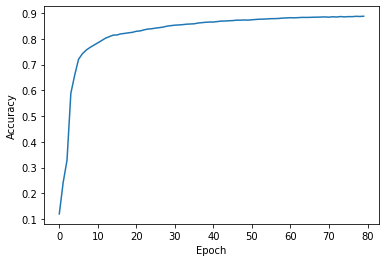

In [45]:
plt.figure()
plt.plot(SGD_trainer.accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

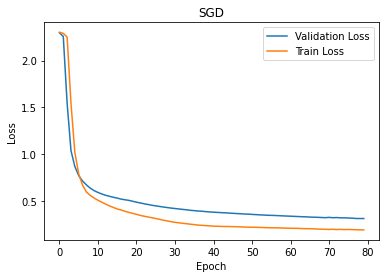

In [44]:
plt.figure()
plt.plot(SGD_trainer.val_losses,label='Validation Loss')
plt.plot(SGD_trainer.train_losses[::len(train_dataloader)+1], label='Train Loss')
plt.legend()
plt.title('SGD')
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Loss')

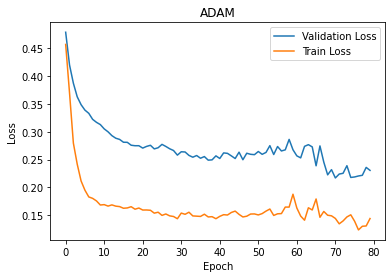

In [41]:
plt.figure()
plt.plot(ADAM_trainer.val_losses,label='Validation Loss')
plt.plot(ADAM_trainer.train_losses[::len(train_dataloader)+1], label='Train Loss')
plt.legend()
plt.title('ADAM')
plt.xlabel('Epoch')
plt.ylabel('Loss')